In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[14300, 8934, 12917, 6172, 7677]

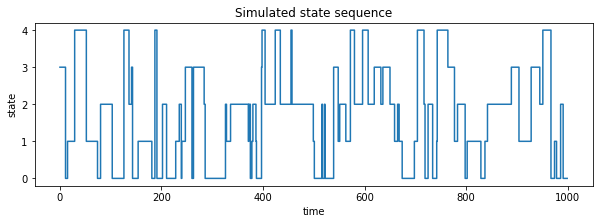

In [2]:
np.random.seed(seed=0)

# simulate state-space series
state_num = 5
time_len = 50000
display_num = 1000
signal_dimension = 10
CNR = 10
window_len = 11
half_window_len = 5

# state transition matrix
switch_prob = (1-0.9)/state_num
a = np.ones(shape=(state_num,state_num)) * switch_prob 
base_prob = np.random.dirichlet(np.ones(state_num)*10) * 0.1
for t in range(state_num):
    a[t,:] = base_prob
    a[t,t] += 0.9
    #a[t,t] = 1 - switch_prob * (state_num - 1)

# simulate states 
state = np.zeros(time_len,dtype=np.uint8)
p = np.random.uniform()
state[0] = np.floor(p*state_num)
for t in range(0,time_len-1):
    p = np.random.uniform()
    for s in range(0,state_num):
        if (p < np.sum(a[state[t],:s+1])):
            state[t+1] = s
            break

# plot first few states            
plt.figure(figsize=(10,3))
plt.step(range(display_num),state[window_len:window_len+display_num])
plt.xlabel('time')
plt.ylabel('state')
plt.title('Simulated state sequence')
[np.sum(state == 0),np.sum(state == 1),np.sum(state == 2),np.sum(state == 3),np.sum(state == 4)]

Text(0.5,1,'Synthetic Bold Signals')

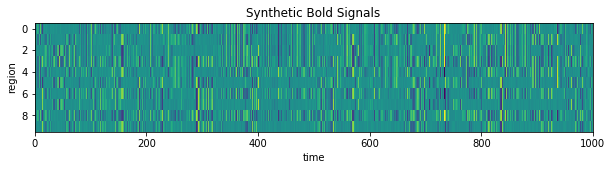

In [3]:
# different states have different loading (connectivity)
loading = np.random.randint(-1, 2,size=(state_num,signal_dimension))
#loading = np.random.uniform(-1, 1, size=(state_num,signal_dimension))
#loading = np.random.normal(size=(state_num,signal_dimension))
cov = np.zeros((state_num,signal_dimension,signal_dimension))
for t in range(state_num):
    cov[t,:,:] = np.matmul(np.transpose([loading[t,:]]),[loading[t,:]])

# generate BOLD signal
signal = np.zeros((time_len,signal_dimension))
for t in range(0,time_len):
    signal[t,:] = np.random.multivariate_normal(np.zeros((signal_dimension)), cov[state[t],:,:])
signal += np.random.normal(size=signal.shape)/CNR
plt.figure(figsize=(10,2))
plt.imshow(np.transpose(signal[window_len:window_len+display_num,:]),aspect='auto')
plt.xlabel('time')
plt.ylabel('region')
plt.title('Synthetic Bold Signals')

Text(0.5,1,'Correlation matrices')

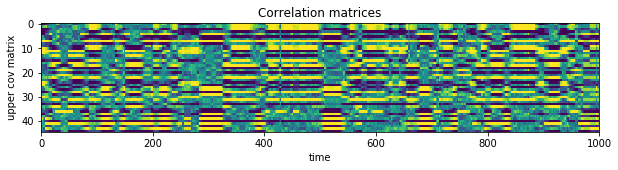

In [4]:
# generate corr matrices
original_dim = np.uint32(signal_dimension*(signal_dimension-1)/2)

x_train = np.zeros(shape=(time_len-window_len*2,np.uint32(original_dim)))
sum_corr = np.zeros(shape=(state_num,original_dim))
occupancy = np.zeros(state_num)

for t in range(window_len,time_len-window_len):
    corr_matrix = np.corrcoef(np.transpose(signal[t-half_window_len:t+half_window_len+1,:]))
    upper = corr_matrix[np.triu_indices(signal_dimension,k=1)]
    x_train[t-window_len,:] = np.squeeze(upper)
    if (np.sum(state[t-half_window_len:t+half_window_len+1] == state[t]) == window_len):
        sum_corr[state[t],:] += x_train[t-window_len,:]
        occupancy[state[t]] += 1

plt.figure(figsize=(10,2))
plt.imshow(np.transpose(x_train[:display_num,:]),aspect='auto')
plt.xlabel('time')
plt.ylabel('upper cov matrix')
plt.title('Correlation matrices')

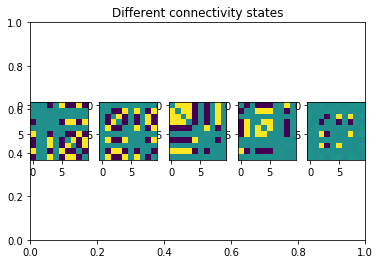

In [5]:
tmp_corr = np.zeros(shape=(signal_dimension,signal_dimension))
mean_corr = sum_corr.copy()

fig = plt.figure()
plt.title("Different connectivity states")
for i in range(state_num):
    ax = fig.add_subplot(1,state_num,i+1)
    mean_corr[i,:] = sum_corr[i,:] / occupancy[i]
    tmp_corr[np.triu_indices(signal_dimension,k=1)] = mean_corr[i,:]
    ax.imshow(tmp_corr+np.transpose(tmp_corr))


In [6]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 36
intermediate_dim_2 = 12
batch_size = 256
latent_dim = 3
cat_dim = 1
class_num = 5
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inter_x1 = Dense(intermediate_dim, activation='tanh', name='encoder_intermediate')(inputs)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_3')(inter_x1)

# add 3 means as additional parameters
dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(class_num*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((class_num,latent_dim), name='mu')(mu_vector)

# prior categorical distribution
pi = Dense(class_num, activation='softmax', name='pi')(dummy)

# posterior categorical distribution
c = Dense(class_num, activation='softmax', name='c')(inter_x2)

# outlier/non-outlier classification (Posterior Beta)
# inter_outlier = Dense(128, activation='relu', name='inter_outlier')(x)
c_outlier = Dense(2, activation='softmax', name='c_outlier')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,dummy], [z_mean, z_log_var, z, mu, c, c_outlier, pi], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_2, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim, activation='tanh')(inter_y1)
outputs = Dense(original_dim, activation='tanh')(inter_y2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs,dummy])[2])
vae = Model([inputs,dummy], outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 45)           0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 36)           1656        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_intermediate_2 (Dense)  (None, 12)           444         encoder_intermediate[0][0]       
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
z_mean (De

In [7]:
models = (encoder, decoder)
dummy_train = np.ones((x_train.shape[0],1))

# weight for outlier Beta prior
# portion of outlier class
Lambda1 = 1
Lambda2 = 50
Alpha = 0.05

# reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = K.tf.multiply(reconstruction_loss, c_outlier[:,0])
reconstruction_loss *= original_dim

# sum over reconstruction loss and kl-div loss
kl_loss_all = K.tf.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=K.tf.float32,initializer=K.tf.zeros_initializer)
kl_cat_all = K.tf.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=K.tf.float32,initializer=K.tf.zeros_initializer)
dir_prior_all = K.tf.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=K.tf.float32,initializer=K.tf.zeros_initializer)

for i in range(0,class_num):
    # stick-breaking reconstruction of categorical distribution
    c_inlier = K.tf.multiply(c[:,i],c_outlier[:,0])
    
    # kl-divergence between q(z|x) and p(z|c)
    kl_loss = 1 + z_log_var - K.square(z_mean-mu[:,i,:]) - K.exp(z_log_var)
    kl_loss = K.tf.multiply(K.sum(kl_loss, axis=-1), c_inlier)
    kl_loss *= -0.5
    kl_loss_all += kl_loss
    
    # kl-divergence between q(c|x) and p(c) (not including outlier class)
    mc = K.mean(c[:,i])
    mpi = K.mean(pi[:,i])
    kl_cat = mc * K.log(mc)- mc * K.log(mpi)
    kl_cat_all += kl_cat
    
    # Dir prior: Dir(3, 3, ..., 3)
    dir_prior = -0.2*K.log(pi[:,i])
    dir_prior_all += dir_prior
    
# kl-divergence between Beta prior and Beta posterior (outlier class)
mco1 = K.mean(c_outlier[:,0])
mco2 = K.mean(c_outlier[:,1])
mpo1 = 1-Alpha
mpo2 = Alpha
kl_cat_outlier = (mco1 * K.log(mco1)- mco1 * np.log(mpo1)+
                  mco2 * K.log(mco2)- mco2 * np.log(mpo2))
          
# total loss
vae_loss = K.mean(reconstruction_loss+
                  kl_loss_all+
                  dir_prior_all+
                  Lambda1*kl_cat_all+
                  Lambda2*kl_cat_outlier)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

#vae.load_weights('vae_mlp_mnist.h5')
vae.fit([x_train,dummy_train],
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 45)           0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 2738        encoder_input[0][0]              
                                                                 dummy[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 45)           2181        encoder[1][2]                    
Total para

1850

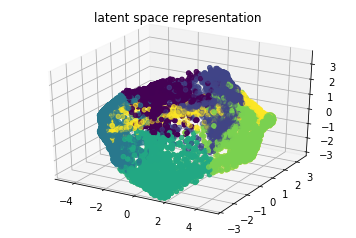

In [8]:
[z_mean, z_log_var, z, mu, c, c_outlier, pi] = encoder.predict([x_train,dummy_train],batch_size=batch_size)

# estimate label

color = np.zeros(x_train.shape[0])
for i in range(0, x_train.shape[0]):
    max_prob = np.max(np.multiply(c[i,:],c_outlier[i,0]))
    idx = np.argmax(np.multiply(c[i,:],c_outlier[i,0]))
    if (max_prob > c_outlier[i,1]):
        color[i] = idx
    else:
        color[i] = class_num
        
# plot latent space   
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mean[color<class_num, 0], z_mean[color<class_num, 1],z_mean[color<class_num,2], c=color[color<class_num])
ax.scatter(z_mean[:, 0], z_mean[:, 1],z_mean[:,2], c=color)
ax.axis('equal')
plt.title('latent space representation')
np.sum(color == 5)

Text(0.5,1,'Reconstructed (decoded) correlation matrices')

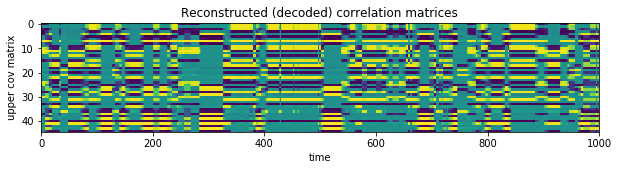

In [9]:
reconstruction = decoder.predict(z_mean,batch_size=batch_size)
plt.figure(figsize=(10,2))
plt.imshow(np.transpose(reconstruction[:display_num,:]),aspect='auto')
plt.xlabel('time')
plt.ylabel('upper cov matrix')
plt.title('Reconstructed (decoded) correlation matrices')

array([0., 3., 1., 2., 4.])

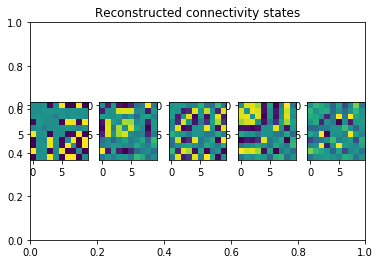

In [10]:
tmp_corr = np.zeros(shape=(signal_dimension,signal_dimension))
recon_mean_corr = mean_corr.copy()
dist = np.zeros(state_num)
perm_link = np.zeros(state_num)

fig = plt.figure()
plt.title("Reconstructed connectivity states")
for i in range(state_num):
    ax = fig.add_subplot(1,state_num,i+1)
    recon_mean_corr[i,:] = np.mean(x_train[color == i,:],axis = 0)
    tmp_corr[np.triu_indices(signal_dimension,k=1)] = recon_mean_corr[i,:]
    for t in range(state_num):
        dist[t] = np.linalg.norm(recon_mean_corr[i,:]-mean_corr[t,:])
    perm_link[i] = np.argmin(dist)
    ax.imshow(tmp_corr+np.transpose(tmp_corr))
perm_link

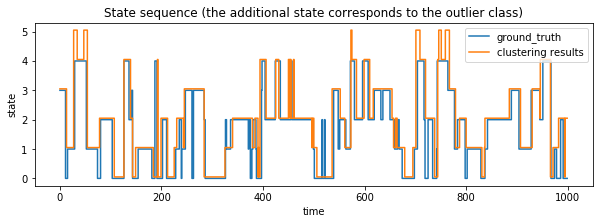

In [11]:
recon_state = color.copy()
for t in range(color.shape[0]):
    if (color[t] < class_num):
        recon_state[t] = perm_link[np.uint32(color[t])]
    else:
        recon_state[t] = class_num

# plot first few states            
plt.figure(figsize=(10,3))
plt.step(range(display_num),state[window_len:window_len+display_num])
plt.step(range(display_num),recon_state[:display_num]+0.05)
plt.xlabel('time')
plt.ylabel('state')
plt.title('State sequence (the additional state corresponds to the outlier class)')
plt.legend(['ground_truth','clustering results'])

In [12]:
# accuracy
state_partial = state[window_len:window_len+recon_state.shape[0]]
#state_partial.shape
np.sum(recon_state[recon_state < class_num] == state_partial[recon_state < class_num]) / np.sum(recon_state < class_num)

0.8329870345744681

In [13]:
pi

array([[0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527],
       [0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527],
       [0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527],
       ...,
       [0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527],
       [0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527],
       [0.20706438, 0.17745398, 0.21022989, 0.23566651, 0.16958527]],
      dtype=float32)